In [1]:
import numpy as np
from lgdo import lh5
from pathlib import Path
from matplotlib import pyplot as plt
import tol_colors as tc
import hist
import awkward as ak
from scipy.stats import beta
import dbetto

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
vib = tc.tol_cset("vibrant")
vset = tc.tol_cset("vibrant")
mset = tc.tol_cset("muted")

style = {
    "yerr": False,
    "flow": None,
    "fill": False,
    "lw": 1,
}

# Get the BuPu colormap
cmap = plt.get_cmap("cividis")

In [2]:
def get_lh5(generator, name, val,threads = 128):
    path = f"{generator}/{name}/max_{val}/"
    hit_directory = Path(f"out/{path}/hit/")
    data = None
    
    for t in range(threads):
        dt = lh5.read_as("germanium/hit", f"{hit_directory}/out_t{t}.lh5", "ak")
        data = ak.concatenate((data,dt)) if data is not None else dt
    return data

n_sim = 100000

In [3]:
# Define bin ranges
bin1 = np.arange(0, 2, 0.5)  # 0.2 keV bins from 0 to 2
bin2 = np.arange(2, 10, 2)  # 2 keV bins from 2 to 10
bin3 = np.arange(10, 50, 10)  # 10 keV bins from 10 to 50
bin4 = np.arange(50, 950, 50)  # 50 keV bins from 50 to 950
bin3 = np.arange(950, 980, 10)  # 10 keV bins from 10 to 50

bin5 = np.arange(980, 998, 2)  # 2 keV bins from 990 to 998
bin6 = np.arange(998, 1002.2, 0.5)  # 0.2 keV bins from 998 to 1002

# Combine all bins into one array
bins = np.unique(np.concatenate([bin1, bin2, bin3, bin4, bin5, bin6]))

In [4]:
def get_binomial_interval(npass, n):
    eff = npass / n
    quantiles = beta.ppf([0.16, 0.84], npass + 1, n - npass + 1)
    err_low = eff - quantiles[0]
    err_high = quantiles[1] - eff
    if err_high <= 0:
        quantiles = beta.ppf([1 - 0.68, 1], npass + 1, n - npass + 1)
        err_low = eff - quantiles[0]
        err_high = quantiles[1] - eff
    elif err_low <= 0:
        quantiles = beta.ppf([0, 0.68], npass + 1, n - npass + 1)
        err_low = eff - quantiles[0]
        err_high = quantiles[1] - eff
    return err_low, err_high

In [5]:
get_binomial_interval(0, 100)

(0.0, 0.011218129756292924)

In [12]:
def plot(
    generator,
    xrange,
    cuts =[0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500,1000] ,
    names=["step_limits"],
    fields=["active_energy_pre"],
    de=2,
    scale="log",
    eff_title=None,
    ylims=None,
    eff_low=999,
    eff_high=1001,
    savename_spec=None,
    savename_eff=None,
    doeff=False,
    figsize=(12, 4),
    legend=True,
    binning=1,
    bs=100,
    factor=1,
    types="all",
    label="Energy [keV]",
):
    if binning is None:
        bins_tmp = np.linspace(0, 10, bs)
    else:
        bins_tmp = bins

    if not isinstance(names, list):
        names = list(names)

    quants = {val / 10: [] for val in range(5)}
    effs = {}
    steps = {}

    # get default
    for field in fields:
        fig, ax = plt.subplots(figsize=figsize)

        ak_obj = get_lh5(generator, f"def_lar_off_{types}", 0)
        ak_obj = ak_obj[ak_obj[field] != 0]
        ak_obj[field] = ak_obj[field] * factor
    
        hist_def = hist.Hist(hist.axis.Variable(bins_tmp)).fill(
            ak_obj[field].to_numpy() + 1e-4
        )
    
        for b in range(hist_def.size - 2):
            hist_def[b] *= 1 / np.diff(bins_tmp)[b]
    
        eff_def = ak.sum((ak_obj[field] > eff_low) & (ak_obj[field] < eff_high))
    
        for name_simple in names:

            name=f"{name_simple}_{types}"
            hist_def.plot(yerr=False, flow=None, fill=True, alpha=0.2, label="No limits")
    
            effs[name] = []
            steps[name] = []
    
            for idx, val in enumerate(cuts):
                ak_obj = get_lh5(generator, name, val)
                ak_obj = ak_obj[ak_obj[field] != 0]
                ak_obj[field] = ak_obj[field] * factor
    
                hist_tmp = hist.Hist(hist.axis.Variable(bins_tmp)).fill(
                    ak_obj[field].to_numpy() + 1e-4
                )
    
                for b in range(hist_tmp.size - 2):
                    hist_tmp[b] *= 1 / np.diff(bins_tmp)[b]
    
                hist_tmp.plot(**style, label=f"{int(val)} um ")
    
                if legend:
                    ax.legend(loc="best")
                    ax.legend(ncol=2)
                    ax.get_legend().set_title(name)
                ax.set_yscale(scale)
                ax.set_xlabel(label)
                ax.set_ylabel("counts")
                ax.set_xlim(*xrange)
    
                if ylims is not None:
                    ax.set_ylim(*ylims)
    
                steps[name].append(val)
                effs[name].append(
                    ak.sum((ak_obj[field] > eff_low) & (ak_obj[field] < eff_high))
                )
            plt.tight_layout()
    
        if savename_spec is not None:
            plt.savefig(savename_spec)
    
        if not doeff:
            return
        fig, ax = plt.subplots()
    
        # get binomial error
        eff_def_low = 100 * get_binomial_interval(eff_def, n_sim)[0]
        eff_def_high = 100 * get_binomial_interval(eff_def, n_sim)[1]
    
        ax.axhspan(
            ymin=100 * eff_def / n_sim - eff_def_low,
            ymax=100 * eff_def / n_sim + eff_def_high,
            label="default",
            alpha=0.2,
            color="grey",
        )
        ax.axhline(y=100 * eff_def / n_sim, color="black", linestyle="--")
    
        for name in effs.keys():
            e = effs[name]
            s = steps[name]
            err_low = [get_binomial_interval(et, n_sim)[0] * 100 for et in e]
            err_high = [get_binomial_interval(et, n_sim)[1] * 100 for et in e]
    
            ax.errorbar(
                s,
                100 * np.array(e) / n_sim,
                yerr=[err_low, err_high],
                fmt=".",
                linestyle="--",
                label=f"varying {name}",
            )
    
        ax.set_xlabel(f"{name} [um]")
        ax.set_ylabel("Efficiency [%]")
    
        if eff_title is not None:
            ax.set_title(eff_title)
    
        ax.legend(loc="best")
        plt.tight_layout()
        if savename_eff is not None:
            plt.savefig(savename_eff)

In [36]:
def plot_performance(generator, name="step_limits", namep=""):
    prof = dbetto.utils.load_dict("profile.yaml")[generator][name]

    size = []
    vals = []
    times = []
    for key, val in sorted(prof.items()):
        size.append(float(val["size"]))
        times.append(float(val["time"]))
        vals.append(float(key))

    idx = np.argsort(vals)
    size = np.array(size)[idx]
    vals = np.array(vals)[idx]
    times = np.array(times)[idx]

    # Create figure and first axis
    fig, ax1 = plt.subplots()

    # Plot the first dataset (sine wave)
    ax1.plot(vals, times, "b-*")
    ax1.set_xlabel(f"{name} [um]")
    ax1.set_ylabel("time [s]", color="b")
    ax1.tick_params(axis="y", labelcolor="b")
    ax1.set_ylim(0, 1.2 * ax1.get_ylim()[1])

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the second dataset (cosine wave)
    ax2.plot(vals, size, "r--.")

    ax2.set_ylabel("Size [MB]", color="r")

    ax2.tick_params(axis="y", labelcolor="r")
    ax2.set_ylim(0, 1.2 * ax2.get_ylim()[1])
    ax2.set_xscale("log")
    # Show the plot
    fig.tight_layout()  # Adjust layout
    
    plt.savefig(namep)

### Beta in bulk

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'out/beta_bulk_all/def_lar_off/max_0/hit/out_t0.lh5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

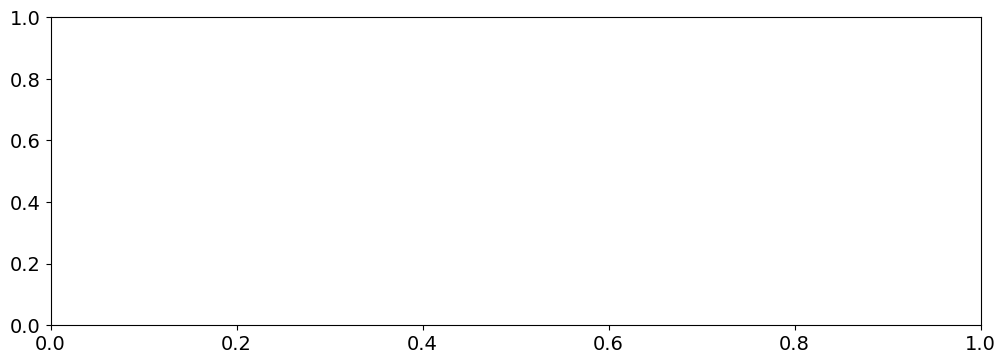

In [8]:
plot(
    "beta_bulk_all",
    (-1, 1020),
    fields=["truth_energy"],
    savename_spec="plots/beta_bulk_steps_truth.pdf",
    savename_eff="plots/beta_bulk_steps_eff_truth.pdf",
    doeff=True,
    figsize=(12, 4),
)
plot(
    "beta_bulk",
    (990, 1010),
    fields=["truth_energy"],
    figsize=(6, 4),
    savename_spec="plots/beta_bulk_peak_truth.pdf",
    legend=False,
)

In [ ]:
plot(
    "beta_bulk",
    (0, 2),
    field="r90",
    factor=1000,
    doeff=True,
    figsize=(12, 4),
    binning=None,
    label="r90 [mm]",
    eff_low=2.5,
    eff_high=20,
    bs=2000,
)

plot(
    "beta_bulk",
    (0, 20),
    field="r90",
    factor=1000,
    doeff=True,
    figsize=(12, 4),
    binning=None,
    label="r90 [mm]",
    eff_low=2.5,
    eff_high=20,
)

In [ ]:
plot(
    "beta_bulk",
    (0, 2),
    field="r90",
    names=["step_limits_PreStep", "step_limits_Average", "step_limits_PostStep"],
    factor=1000,
    doeff=True,
    figsize=(12, 4),
    binning=None,
    label="r90 [mm]",
    eff_low=0.25,
    eff_high=0.5,
    bs=2000,
)

In [ ]:
plot(
    "beta_bulk",
    (-1, 1020),
    names=["step_limits_PreStep", "step_limits_Average", "step_limits_PostStep"],
    field="active_energy",
    doeff=True,
    figsize=(12, 4),
)
plot(
    "beta_bulk",
    (-1, 1020),
    names=["step_limits_PostStep"],
    field="active_energy",
    doeff=True,
    figsize=(12, 4),
)
plot(
    "beta_bulk",
    (-1, 1020),
    names=["step_limits_Average"],
    field="active_energy",
    doeff=True,
    figsize=(12, 4),
)

plot(
    "beta_bulk",
    (-1, 11),
    ylims=(100, 2000),
    figsize=(6, 4),
    savename_spec="plots/beta_bulk_steps_low.pdf",
    legend=False,
)
plot(
    "beta_bulk",
    (990, 1010),
    field="active_energy",
    figsize=(6, 4),
    savename_spec="plots/beta_bulk_peak.pdf",
    legend=False,
)

In [ ]:
plot_performance("beta_bulk", namep="plots/beta_bulk_perf.pdf")

In [ ]:
plot("beta_bulk", (-1, 1020), field="truth_energy", doeff=True, figsize=(12, 4))
plot(
    "beta_bulk",
    (990, 1010),
    field="truth_energy",
    figsize=(6, 4),
    savename_spec="plots/beta_bulk_peak_truth.pdf",
    legend=False,
)

# gamma bulk

In [ ]:
plot(
    "gamma_bulk",
    (-1, 1020),
    field="truth_energy",
    savename_spec="plots/gamma_bulk_steps_truth.pdf",
    savename_eff="plots/gamma_bulk_steps_eff_truth.pdf",
    doeff=True,
    figsize=(12, 4),
)
plot(
    "gamma_bulk",
    (990, 1010),
    field="truth_energy",
    figsize=(6, 4),
    savename_spec="plots/gamma_bulk_peak_truth.pdf",
    legend=False,
)

In [ ]:
plot(
    "gamma_bulk",
    (-1, 1020),
    field="active_energy",
    savename_spec="plots/gamma_bulk_steps.pdf",
    savename_eff="plots/beta_bulk_steps_eff.pdf",
    doeff=True,
    figsize=(12, 4),
)

 # Beta suirface

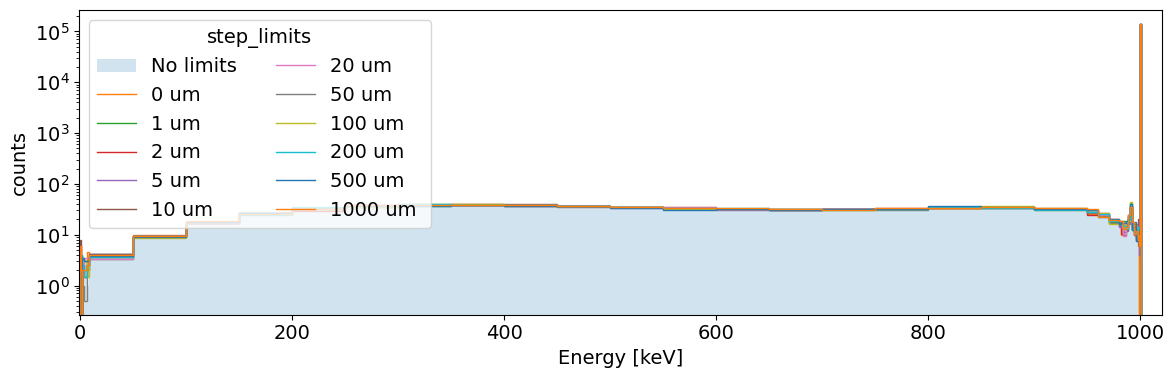

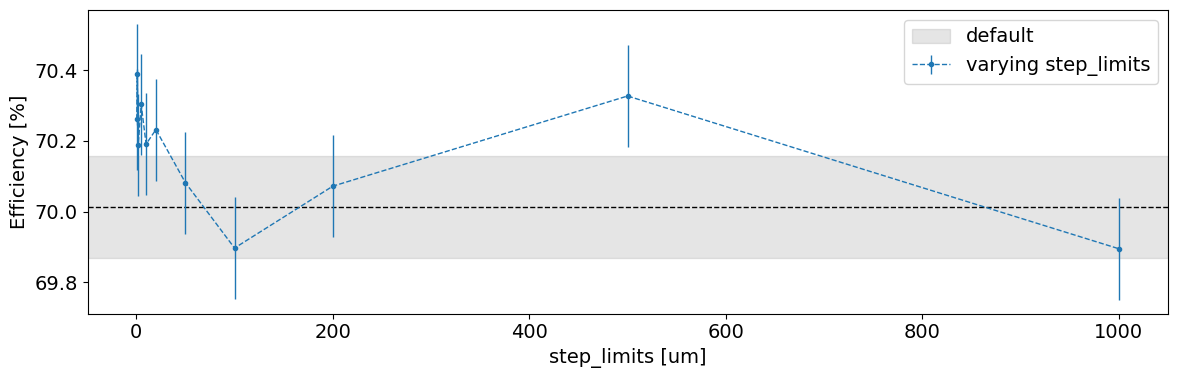

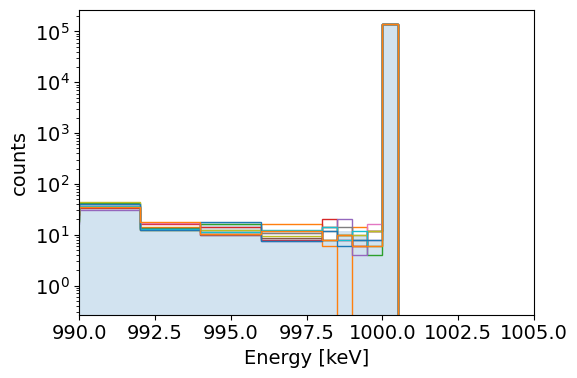

In [37]:
plot(
    "beta_surf",
    (-1, 1020),
    field="truth_energy",
    eff_low=999,
    eff_high=1001,
    doeff=True,
)
plot(
    "beta_surf",
    (990, 1005),
    field="truth_energy",
    figsize=(6, 4),
    legend=False,
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'out/beta_surf/def_lar_off_all/max_0/hit/out_t0.lh5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

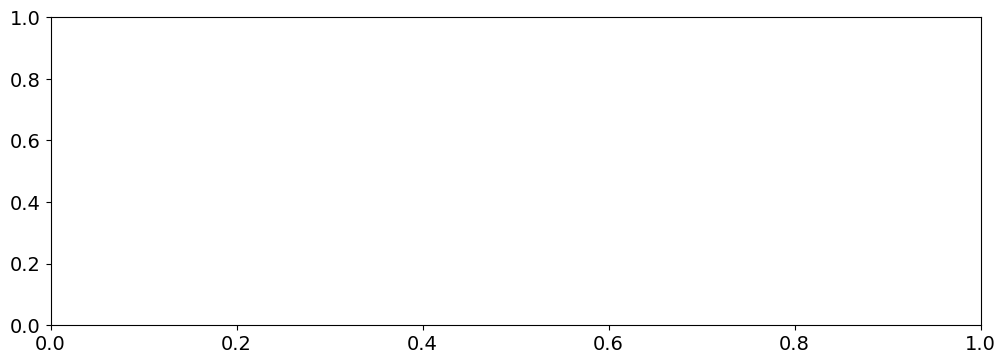

In [13]:
plot(
    "beta_surf",
    (200, 600),
    fields=["active_energy"],
    names=["step_limits"],
    types="all",
    label="Energy [keV]",
    eff_low=300,
    scale="linear",
    eff_title="300 - 1000 keV",
    eff_high=1000,
    doeff=True,
    ylims=(0, 70),
)

In [ ]:
plot(
    "beta_bulk",
    (0, 1200),
    field="active_energy",
    names=["step_limits_PreStep", "step_limits_Average", "step_limits_PostStep"],
    eff_low=999,
    scale="linear",
    eff_title="1000 +/- 1 keV",
    eff_high=1001,
    doeff=True,
)

In [ ]:
plot(
    "beta_surf",
    (200, 600),
    field="active_energy",
    names=["step_limits_PreStep", "step_limits_Average", "step_limits_PostStep"],
    eff_low=300,
    scale="linear",
    eff_title="300 - 1000 keV",
    eff_high=1000,
    doeff=True,
    ylims=(0, 70),
)

In [ ]:
plot(
    "beta_surf",
    (0, 1),
    field="max_z",
    binning=None,
    label="max z [mm]",
    names=["step_limits_PreStep", "step_limits_Average", "step_limits_PostStep"],
    eff_low=0.6,
    scale="linear",
    eff_title="Max z in [0.6 - 2]mm",
    eff_high=1.1,
    doeff=True,
)

In [ ]:
plot(
    "beta_surf",
    (-1, 1020),
    field="active_energy",
    eff_low=200,
    eff_title="200 - 300 keV",
    eff_high=300,
    doeff=True,
    savename_spec="plots/beta_surf_spec.pdf",
    savename_eff="plots/beta_surf_steps_eff_200_300.pdf",
)

plot(
    "beta_surf",
    (-1, 1020),
    field="active_energy",
    eff_low=100,
    eff_high=200,
    eff_title="100 - 200 keV",
    doeff=True,
    savename_spec="plots/beta_surf_spec.pdf",
    savename_eff="plots/beta_surf_steps_eff_100_200.pdf",
)

plot(
    "beta_surf",
    (-1, 11),
    ylims=(200, 6000),
    figsize=(6, 4),
    savename_spec="plots/beta_surf_steps_low.pdf",
    legend=False,
)

In [ ]:
plot_performance("beta_surf", namep="plots/beta_surf_perf.pdf")

# Prod cuts

In [ ]:
plot(
    "beta_bulk",
    (-1, 1020),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="truth_energy",
    doeff=True,
    savename_spec="plots/beta_bulk_cuts_spectrum_truth.pdf",
    savename_eff="plots/beta_bulk_cuts_eff_truth.pdf",
)

plot("beta_bulk", (980, 1005), name="sens_prod_cuts", step_range=(5, 145, 8))

In [ ]:
plot(
    "beta_bulk",
    (-1, 1020),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="active_energy",
    doeff=True,
    savename_spec="plots/beta_bulk_cuts_spectrum.pdf",
    savename_eff="plots/beta_bulk_cuts_eff.pdf",
)

plot(
    "beta_bulk",
    (980, 1005),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    savename_spec="plots/beta_bulk_cuts_peak.pdf",
    figsize=(6, 4),
    legend=False,
)

In [ ]:
plot_performance(
    "beta_bulk", name="sens_prod_cuts", namep="plots/beta_bulk_cuts_perf.pdf"
)

In [ ]:
plot_performance(
    "beta_bulk", name="def_prod_cuts_lar_off", namep="plots/beta_bulk_cuts_perf.pdf"
)

In [ ]:
plot(
    "beta_bulk",
    (0, 2),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="r90",
    factor=1000,
    doeff=True,
    figsize=(12, 4),
    binning=None,
    label="r90 [mm]",
    eff_low=2.5,
    eff_high=20,
    bs=2000,
)

plot(
    "beta_bulk",
    (0, 20),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="r90",
    factor=1000,
    doeff=True,
    figsize=(12, 4),
    binning=None,
    label="r90 [mm]",
    eff_low=2.5,
    eff_high=20,
)

# Gamma bulk - prod cuts

In [ ]:
plot(
    "gamma_bulk",
    (-1, 1020),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="active_energy",
    savename_spec="plots/gamma_bulk_cuts.pdf",
    savename_eff="plots/beta_bulk_cuts_eff.pdf",
    doeff=True,
    figsize=(12, 4),
)

## Beta surf - production cuts

In [ ]:
plot(
    "beta_surf",
    (-1, 1020),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="truth_energy",
    doeff=True,
    savename_spec="plots/beta_surf_cuts_spectrum_truth.pdf",
    savename_eff="plots/beta_surf_cuts_eff_truth.pdf",
)

In [ ]:
plot(
    "beta_surf",
    (-1, 1020),
    name="sens_prod_cuts",
    step_range=(5, 145, 8),
    field="active_energy",
    doeff=True,
    eff_low=300,
    eff_high=1000,
    savename_spec="plots/beta_surf_cuts_spectrum.pdf",
    savename_eff="plots/beta_surf_cuts_eff.pdf",
)

In [ ]:
plot_performance(
    "beta_surf", name="sens_prod_cuts", namep="plots/beta_surf_cuts_perf.pdf"
)

### External gammas

In [ ]:
plot_performance("gamma_external", name="def_prod_cuts_lar_off")
plot_performance("gamma_external", name="def_prod_cuts_lar_on")

In [ ]:
plot(
    "gamma_external",
    (-1, 1020),
    name="def_prod_cuts_lar_on",
    step_range=(10, 490, 5),
    field="active_energy",
    doeff=True,
    eff_low=999,
    eff_high=1001,
    factor=1,
)